__DATA CLEANING__

In [1]:
import re
import html
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
df = pd.read_csv("../data/paycell_reviews_play_store.csv")
df

,Yorum,Puan,Tarih
0,şuan uygulama da sorunlar var bankadan karta p...,1,2025-07-07 10:25:20
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,1,2025-07-07 09:08:45
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,1,2025-07-06 22:22:35
3,yabancı olduğum için doğrulama yapamıyorum,1,2025-07-06 20:02:06
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,3,2025-07-06 18:34:42
...,...,...,...
68634,Çok güzel,5,2017-08-25 10:43:11
68635,Mobil ödeme bakiye ve islem tarihcesi goruntul...,5,2017-08-19 15:08:30
68636,Beklemedeyiz,4,2017-08-17 06:38:45
68637,Fine hit :),5,2017-08-16 20:23:34


In [3]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # html
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = html.unescape(text)

    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\sçğıöşüÇĞİÖŞÜ]', '', text, flags=re.UNICODE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002700-\U000027BF"
        "\U0001F900-\U0001F9FF"
        "\U00002600-\U000026FF"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    return text


In [4]:
df['Temiz_Yorum'] = df['Yorum'].apply(clean_text)
df[['Yorum', 'Temiz_Yorum']]

,Yorum,Temiz_Yorum
0,şuan uygulama da sorunlar var bankadan karta p...,şuan uygulama da sorunlar var bankadan karta p...
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,bir türlü decont alamıyoruz bazı yerler ödeme ...
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,bu nasıl bir uygulama bir haftadır açmaya çalı...
3,yabancı olduğum için doğrulama yapamıyorum,yabancı olduğum için doğrulama yapamıyorum
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,şifre güncelle diyorsunuz ama guncelletmiuorsu...
...,...,...
68634,Çok güzel,çok güzel
68635,Mobil ödeme bakiye ve islem tarihcesi goruntul...,mobil ödeme bakiye ve islem tarihcesi goruntul...
68636,Beklemedeyiz,beklemedeyiz
68637,Fine hit :),fine hit


In [5]:
from jpype import startJVM, getDefaultJVMPath, JClass, isJVMStarted

ZEMBEREK_PATH = "zemberek-full.jar"

if not isJVMStarted():
    startJVM(getDefaultJVMPath(), "-ea", f"-Djava.class.path={ZEMBEREK_PATH}")

In [6]:
TurkishSpellChecker = JClass("zemberek.normalization.TurkishSpellChecker")
TurkishMorphology = JClass("zemberek.morphology.TurkishMorphology")
morphology = TurkishMorphology.createWithDefaults()
spell_checker = TurkishSpellChecker(morphology)

In [7]:
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if spell_checker.check(word):
            corrected_words.append(str(word))  
        else:
            suggestions = spell_checker.suggestForWord(word)
            if not suggestions.isEmpty():
                corrected_words.append(str(suggestions.get(0))) 
            else:
                corrected_words.append(str(word))
    return " ".join(corrected_words)


In [8]:
df["yazim_hatasiz"] = df["Temiz_Yorum"].astype(str).apply(correct_spelling)
df[["Yorum", "yazim_hatasiz"]]

,Yorum,yazim_hatasiz
0,şuan uygulama da sorunlar var bankadan karta p...,şuan uygulama da sorunlar var bankadan karta p...
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,bir türlü dekont alamıyoruz bazı yerler ödeme ...
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,bu nasıl bir uygulama bir haftadır açmaya çalı...
3,yabancı olduğum için doğrulama yapamıyorum,yabancı olduğum için doğrulama yapamıyorum
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,şifre güncelle diyorsunuz ama guncelletmiuorsu...
...,...,...
68634,Çok güzel,çok güzel
68635,Mobil ödeme bakiye ve islem tarihcesi goruntul...,mobil ödeme bakiye ve işlem tarihçesi goruntul...
68636,Beklemedeyiz,beslemedeyiz
68637,Fine hit :),fine hit


__PREPROCESSING__ 

STOPWORDS AND TOKENAZATION

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\ismet
[nltk_data]     bal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words("turkish"))

def remove_stopwords(text):
    tokens = text.split() 
    filtered_tokens = [word.lower() for word in tokens 
                       if word.lower() not in stop_words and
                       word not in string.punctuation and
                       len(word) > 2]
    return filtered_tokens

df = df[df["yazim_hatasiz"].notnull()]
df["tokens"] = df["yazim_hatasiz"].astype(str).apply(remove_stopwords)
df[["Yorum", "yazim_hatasiz", "tokens"]]

,Yorum,yazim_hatasiz,tokens
0,şuan uygulama da sorunlar var bankadan karta p...,şuan uygulama da sorunlar var bankadan karta p...,"[şuan, uygulama, sorunlar, var, bankadan, kart..."
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,bir türlü dekont alamıyoruz bazı yerler ödeme ...,"[bir, türlü, dekont, alamıyoruz, yerler, ödeme..."
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,bu nasıl bir uygulama bir haftadır açmaya çalı...,"[bir, uygulama, bir, haftadır, açmaya, çalışıy..."
3,yabancı olduğum için doğrulama yapamıyorum,yabancı olduğum için doğrulama yapamıyorum,"[yabancı, olduğum, doğrulama, yapamıyorum]"
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,şifre güncelle diyorsunuz ama guncelletmiuorsu...,"[şifre, güncelle, diyorsunuz, guncelletmiuorsu..."
...,...,...,...
68634,Çok güzel,çok güzel,[güzel]
68635,Mobil ödeme bakiye ve islem tarihcesi goruntul...,mobil ödeme bakiye ve işlem tarihçesi goruntul...,"[mobil, ödeme, bakiye, işlem, tarihçesi, gorun..."
68636,Beklemedeyiz,beslemedeyiz,[beslemedeyiz]
68637,Fine hit :),fine hit,"[fine, hit]"


__ZEMBEREK USING STEMMING AND LEMMAZATION__

Spelling Correction 

In [12]:
def lemmatizeTokens(tokens, morphology):
    lemmas = []
    for tok in tokens:
        analyses = morphology.analyzeAndDisambiguate(tok).bestAnalysis()
        if analyses.size() > 0:
            lemma = str(analyses.get(0).getLemmas()[0])
            lemmas.append(lemma if lemma != 'UNK' else tok)
        else:
            lemmas.append(tok)
    return lemmas

df["lemmas"] = df["tokens"].apply(lambda x: lemmatizeTokens(x, morphology))

In [13]:
df[["Yorum", "tokens", "lemmas"]]

,Yorum,tokens,lemmas
0,şuan uygulama da sorunlar var bankadan karta p...,"[şuan, uygulama, sorunlar, var, bankadan, kart...","[şua, uygula, sorun, var, banka, kart, para, a..."
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,"[bir, türlü, dekont, alamıyoruz, yerler, ödeme...","[bir, türlü, dekont, al, yer, öde, yap, dair, ..."
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,"[bir, uygulama, bir, haftadır, açmaya, çalışıy...","[bir, uygula, bir, hafta, aç, çalışıyum, aç, g..."
3,yabancı olduğum için doğrulama yapamıyorum,"[yabancı, olduğum, doğrulama, yapamıyorum]","[yabancı, ol, doğrula, yap]"
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,"[şifre, güncelle, diyorsunuz, guncelletmiuorsu...","[şifre, güncelle, de, guncelletmiuorsunuz, yapı]"
...,...,...,...
68634,Çok güzel,[güzel],[güzel]
68635,Mobil ödeme bakiye ve islem tarihcesi goruntul...,"[mobil, ödeme, bakiye, işlem, tarihçesi, gorun...","[mobil, öde, bakiye, işlem, tarihçe, goruntule..."
68636,Beklemedeyiz,[beslemedeyiz],[besleme]
68637,Fine hit :),"[fine, hit]","[fin, hit]"


In [14]:
df = df[df["lemmas"].apply(lambda x: len(x) > 0)]

In [15]:
remove_words = set(["uygula", "yap", "et", "ver", "al", "bir", "ol", "de", "ben", "gel"])

def clean_lemmas(val):
    try:
        # Eğer string ise listeye çevir
        if isinstance(val, str):
            val = ast.literal_eval(val)
        # Temizle
        return [w for w in val if w.lower() not in remove_words]
    except Exception as e:
        print(f"Hata: {e} → {val}")
        return []

df["lemmas"] = df["lemmas"].apply(clean_lemmas)


In [16]:
df.head()


,Yorum,Puan,Tarih,Temiz_Yorum,yazim_hatasiz,tokens,lemmas
0,şuan uygulama da sorunlar var bankadan karta p...,1,2025-07-07 10:25:20,şuan uygulama da sorunlar var bankadan karta p...,şuan uygulama da sorunlar var bankadan karta p...,"[şuan, uygulama, sorunlar, var, bankadan, kart...","[şua, sorun, var, banka, kart, para, at, hata,..."
1,bir türlü decont alamıyoruz. bazı yerler ödeme...,1,2025-07-07 09:08:45,bir türlü decont alamıyoruz bazı yerler ödeme ...,bir türlü dekont alamıyoruz bazı yerler ödeme ...,"[bir, türlü, dekont, alamıyoruz, yerler, ödeme...","[türlü, dekont, yer, öde, dair, dekont, iste, ..."
2,bu nasıl bir uygulama bir haftadır açmaya çalı...,1,2025-07-06 22:22:35,bu nasıl bir uygulama bir haftadır açmaya çalı...,bu nasıl bir uygulama bir haftadır açmaya çalı...,"[bir, uygulama, bir, haftadır, açmaya, çalışıy...","[hafta, aç, çalışıyum, aç, güvenlik, anahtar, ..."
3,yabancı olduğum için doğrulama yapamıyorum,1,2025-07-06 20:02:06,yabancı olduğum için doğrulama yapamıyorum,yabancı olduğum için doğrulama yapamıyorum,"[yabancı, olduğum, doğrulama, yapamıyorum]","[yabancı, doğrula]"
4,şifre güncelle diyorsunuz ama guncelletmiuorsu...,3,2025-07-06 18:34:42,şifre güncelle diyorsunuz ama guncelletmiuorsu...,şifre güncelle diyorsunuz ama guncelletmiuorsu...,"[şifre, güncelle, diyorsunuz, guncelletmiuorsu...","[şifre, güncelle, guncelletmiuorsunuz, yapı]"


In [17]:
df[["lemmas", "Puan", "Tarih"]].to_csv("../data/preprocessed_review.csv", index = False)

In [18]:
df = pd.read_csv("../data/preprocessed_review.csv")

In [19]:
df.head()

,lemmas,Puan,Tarih
0,"['şua', 'sorun', 'var', 'banka', 'kart', 'para...",1,2025-07-07 10:25:20
1,"['türlü', 'dekont', 'yer', 'öde', 'dair', 'dek...",1,2025-07-07 09:08:45
2,"['hafta', 'aç', 'çalışıyum', 'aç', 'güvenlik',...",1,2025-07-06 22:22:35
3,"['yabancı', 'doğrula']",1,2025-07-06 20:02:06
4,"['şifre', 'güncelle', 'guncelletmiuorsunuz', '...",3,2025-07-06 18:34:42


In [20]:
df['review_length'] = df['lemmas'].apply(lambda x: len(str(x).split()))
df['review_length'].describe()

count    66294.000000
mean         5.784505
std          8.444583
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        116.000000
Name: review_length, dtype: float64

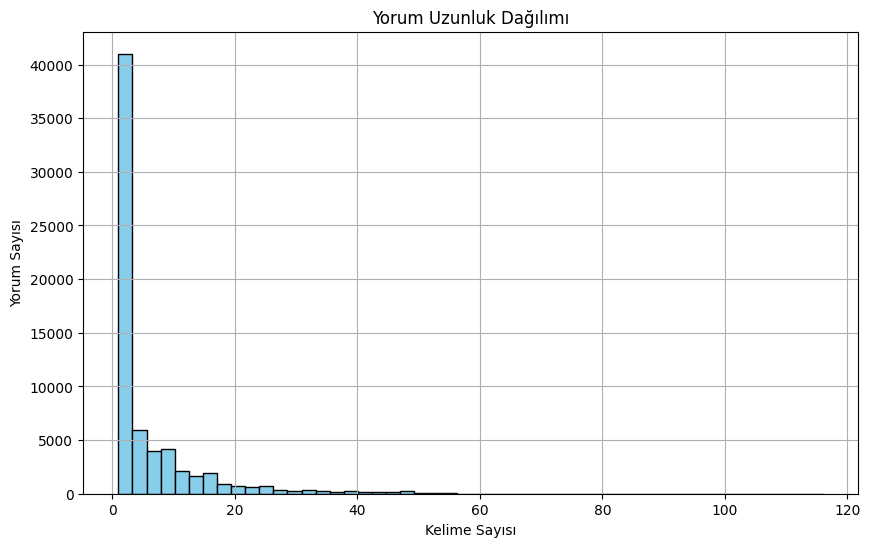

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Yorum Uzunluk Dağılımı")
plt.xlabel("Kelime Sayısı")
plt.ylabel("Yorum Sayısı")
plt.grid(True)
plt.show()


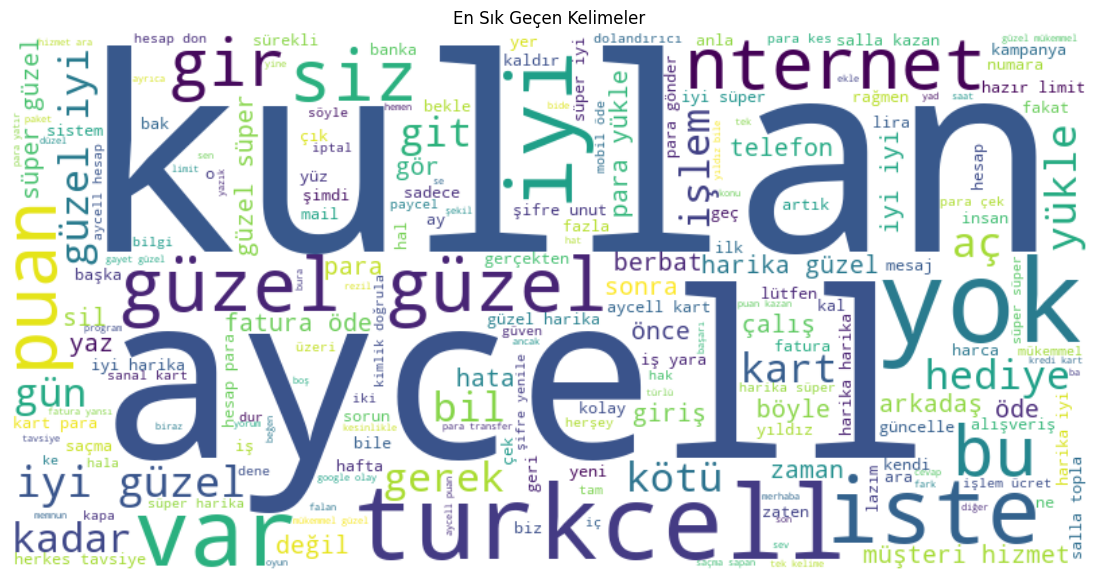

In [22]:
import ast

df['lemmas'] = df['lemmas'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

all_words = [word for tokens in df['lemmas'] for word in tokens]
text = " ".join(all_words)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("En Sık Geçen Kelimeler")
plt.show()


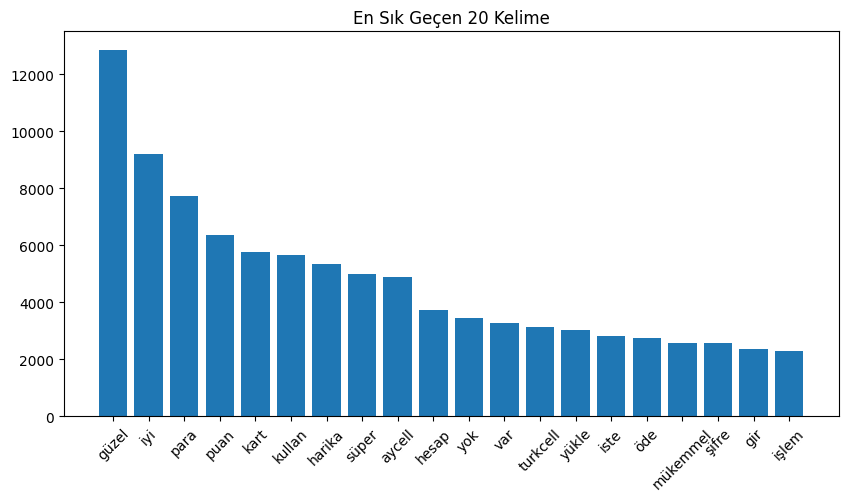

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = [word for tokens in df["lemmas"] for word in tokens if word.lower() not in stop_words]
word_freq = Counter(all_words).most_common(20)

words, freqs = zip(*word_freq)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("En Sık Geçen 20 Kelime")
plt.show()
